In [40]:
# using GuSTO"
include("../src/GuSTO.jl")

Forest

In [65]:
robot = Astrobee3D()
model = AstrobeeSE3Manifold()
env = ISSCorner();

N = 50
tf_guess = 10.
goal_set = GoalSet()

add_obstacles!(env)

# Small corner maneuver
r_init = [11.2; -0.8; 5.6]
r_goal = [10.9; 3.0; 5.0]

q_init = [1.; 0.; 0.; 0.]
# q_goal = [1.; 0.; 0.; 0.]
# q_goal = [1.; 0.5; 0.5; 0.5]
q_goal = [1.; 0.2; 0.3; 0.4]
q_goal = q_goal/norm(q_goal)

x_init = [r_init; zeros(3); q_init; zeros(3)]
v_goal = zeros(3)
ω_goal = zeros(3)

x_goal = [r_goal; v_goal; q_goal; ω_goal]
# add_goal!(goal_set, Goal(PointGoal(x_goal), tf_guess, model))

ε = 1e-4
add_goal!(goal_set, Goal(PointGoal(r_goal), tf_guess, 1:3))
add_goal!(goal_set, Goal(PointGoal(v_goal), tf_guess, 4:6))
add_goal!(goal_set, Goal(BoxGoal(q_goal.-ε, q_goal.+ε), tf_guess, 7:10))
# add_goal!(goal_set, Goal(PointGoal(q_goal), tf_guess, 7:10))
add_goal!(goal_set, Goal(PointGoal(ω_goal), tf_guess, 11:13))

PD = ProblemDefinition(robot, model, env, x_init, goal_set);
TOP = TrajectoryOptimizationProblem(PD, N, tf_guess, fixed_final_time=true)
TOS_SCP = TrajectoryOptimizationSolution(TOP)

solve_SCP!(TOS_SCP, TOP, solve_gusto_jump!, init_traj_straightline, "Ipopt", print_level=0)

In [66]:
@show TOS_SCP.SCPS.converged
@show TOS_SCP.SCPS.iterations
@show TOS_SCP.SCPS.total_time
@show TOS_SCP.SCPS.accept_solution
@show TOS_SCP.SCPS.solver_status
@show TOS_SCP.SCPS.scp_status
@show TOS_SCP.SCPS.convergence_measure
@show TOS_SCP.SCPS.param.alg.ω_vec
@show TOS_SCP.SCPS.param.alg.Δ_vec
@show TOS_SCP.SCPS.J_true
@show TOS_SCP.SCPS.dual
;

(TOS_SCP.SCPS).converged = false
(TOS_SCP.SCPS).iterations = 9
(TOS_SCP.SCPS).total_time = 25.634153125
(TOS_SCP.SCPS).accept_solution = Bool[true, true, true, true, true, true, true, true, true, true]
(TOS_SCP.SCPS).solver_status = Union{TerminationStatusCode, Symbol}[:NA, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_SOLVED, LOCALLY_INFEASIBLE]
(TOS_SCP.SCPS).scp_status = Symbol[:NA, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints, :ViolatesConstraints]
(TOS_SCP.SCPS).convergence_measure = [0.0, 0.0845602, 0.00306601, 0.00467284, 0.00196266, 0.00581449, 0.0035658, 0.00339861, 0.00137551, 0.000129339]
(((TOS_SCP.SCPS).param).alg).ω_vec = [1.0, 5.0, 25.0, 125.0, 625.0, 3125.0, 15625.0, 78125.0, 390625.0, 1.95313e6]
(((TOS_SCP.SCPS).param).alg).Δ_vec = [1000.0, 1000.0, 1000

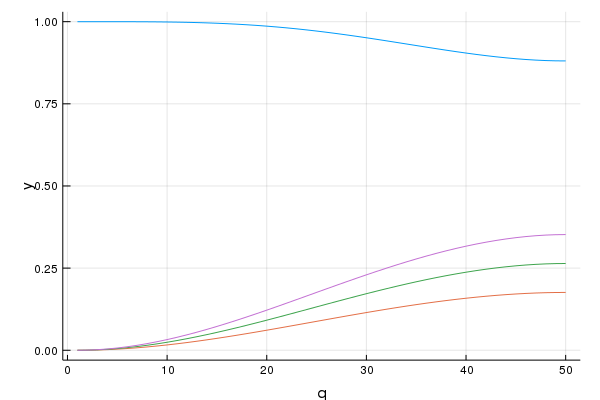

In [36]:
using Plots
gr(fmt=:png)
plot()
for i = 7:10
    plot!([collect(1:N)],[TOS_SCP.SCPS.traj.X[i,:]],
        xlabel = "q",
        ylabel = "y",
        legend = :none)
end
plot!()

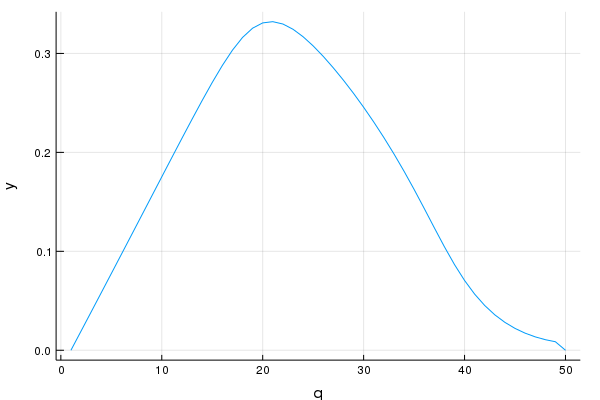

In [37]:
gr(fmt=:png)
plot()
plot!([collect(1:N)],[TOS_SCP.SCPS.traj.X[4,:]],
    xlabel = "q",
    ylabel = "y",
    legend = :none)

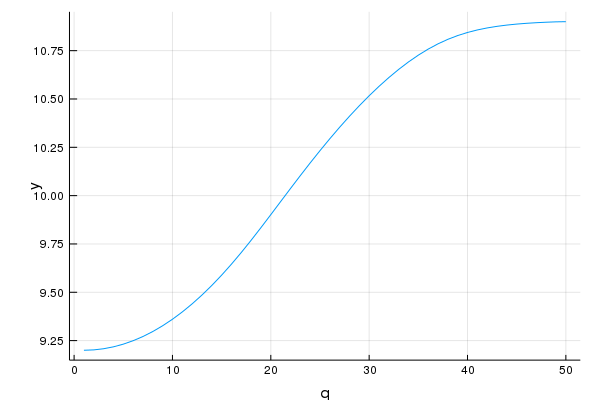

In [38]:
gr(fmt=:png)
plot()
plot!([collect(1:N)],[TOS_SCP.SCPS.traj.X[1,:]],
    xlabel = "q",
    ylabel = "y",
    legend = :none)

In [64]:
using AstrobeeRobot

# Animate Astrobee trajectory
vis = Visualizer()
delete!(vis)

vis[:goal]
for (idx,obs) in enumerate(env.keepout_zones)
    setobject!(vis[:goal][:goal], 
        Object(HyperSphere(Point3f0(x_goal[1:3]), 0.1f0),
            MeshBasicMaterial(color=RGBA(0,1.0,0.,0.3))))
end

vis[:workspace]
for (idx,ws) in enumerate(env.keepin_zones)
    if idx in (5,8)
        setobject!(vis[:workspace][Symbol(string("ws",idx))],
            Object(ws, MeshBasicMaterial(color=RGBA(0.95,0.93,0.26,0.3), depthWrite=false)))
    else
        setobject!(vis[:workspace][Symbol(string("ws",idx))],
            Object(ws, MeshBasicMaterial(color=RGBA(0.95,0.93,0.26,0.3))))
    end
end

vis[:obstacle]
for (idx,ws) in enumerate(env.obstacle_set)
    setobject!(vis[:workspace][Symbol(string("ws",idx+length(env.keepin_zones)))],
        Object(ws,MeshBasicMaterial(color=RGBA(0.95,0.26,0.26,0.3))))
end

ab = Astrobee()
mvis = MechanismVisualizer(
    ab.mechanism,
    URDFVisuals(AstrobeeRobot.urdfpath(), package_path=[dirname(dirname(AstrobeeRobot.urdfpath()))]),
    vis);

speed_factor = 3

Qs = Vector{Vector{Float64}}()
for k in 1:speed_factor:N
#     q = [quat_inv(TOS_SCP.SCPS.traj.X[7:10,k]); TOS_SCP.SCPS.traj.X[1:3,k]]
    q = [quat_inv(TOS_SCP.SCPS.traj.X[7:10,k]); TOS_SCP.SCPS.traj.X[1:3,k]]
    push!(Qs,q)
end

trans = Translation(14., -1., 7.)
rot = LinearMap(RotZ(-0.6)) ∘ LinearMap(RotY(-0.2))
settransform!(vis["/Cameras/default"], trans ∘ rot)
setprop!(vis["/Cameras/default/rotated/<object>"], "zoom", 1.9)
setprop!(vis["/Cameras/default/rotated/<object>"], "near", 0.05)

sleep(3)
setanimation!(mvis,1:length(Qs),Qs)

plot_in_cell = false
plot_in_cell ? IJuliaCell(vis) : open(vis)

instantiated a floating joint


┌ Info: Serving MeshCat visualizer at http://127.0.0.1:8702
└ @ MeshCat /home/bylard/.julia/packages/MeshCat/WlA0B/src/servers.jl:24


Process(`xdg-open http://127.0.0.1:8702`, ProcessExited(0))

/usr/bin/google-chrome-stable: /home/bylard/.julia/v0.6/Conda/deps/usr/lib/libuuid.so.1: no version information available (required by /usr/bin/google-chrome-stable)
/opt/google/chrome/chrome: /home/bylard/.julia/v0.6/Conda/deps/usr/lib/libuuid.so.1: no version information available (required by /opt/google/chrome/chrome)
GLib-GIO-Message: 18:46:21.494: Using the 'memory' GSettings backend.  Your settings will not be saved or shared with other applications.
[17567:17593:0416/184621.525444:ERROR:bus.cc(396)] Failed to connect to the bus: Failed to connect to socket /home/bylard/.julia/v0.6/Conda/deps/usr/var/run/dbus/system_bus_socket: No such file or directory
/proc/self/exe: /home/bylard/.julia/v0.6/Conda/deps/usr/lib/libuuid.so.1: no version information available (required by /proc/self/exe)
/proc/self/exe: /home/bylard/.julia/v0.6/Conda/deps/usr/lib/libuuid.so.1: no version information available (required by /proc/self/exe)


Opening in existing browser session.
